# Problem 5.3: Training Dynamics Comparison (4 points)

Train all 4 networks (Zero, Small Random, Xavier, He) for **10 epochs** on MNIST:
- **Optimizer:** SGD with learning rate 0.1
- **Batch size:** 128
- **Loss:** CrossEntropyLoss

**Tasks:**
1. Plot all 4 training loss curves on the same figure.
2. Report the test accuracy after 10 epochs for each initialization.

**Note:** Zero initialization is expected to fail completely (no learning) due to symmetry. If your zero-initialized network shows no learning, your implementation is likely correct.

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [2]:
# MNIST: batch size 128 for training
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0)
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 469, Test batches: 40


In [3]:
def initialize_weights(shape, method):
    if len(shape) != 2:
        raise ValueError("Shape must be (fan_in, fan_out)")
    fan_in, fan_out = shape
    if method == "zero":
        return torch.zeros(shape)
    elif method == "small_random":
        return torch.randn(shape) * 0.01
    elif method == "xavier":
        return torch.randn(shape) * math.sqrt(2 / (fan_in + fan_out))
    elif method == "he":
        return torch.randn(shape) * math.sqrt(2 / fan_in)
    else:
        raise ValueError("Unknown method")

class MLPLayer(nn.Module):
    """6-layer MLP: 784 → 256×5 → 10, Tanh hidden."""
    def __init__(self, init_method="xavier"):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 10)
        self.act = nn.Tanh()
        for m in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6]:
            w = initialize_weights((m.in_features, m.out_features), init_method)
            m.weight.data = w.t()
            m.bias.data.zero_()

    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.act(self.fc2(h))
        h = self.act(self.fc3(h))
        h = self.act(self.fc4(h))
        h = self.act(self.fc5(h))
        return self.fc6(h)  # logits only for training

In [4]:
# Train all 4 networks for 10 epochs; record training loss per epoch
epochs = 10
criterion = nn.CrossEntropyLoss()
inits = ["zero", "small_random", "xavier", "he"]
history = {name: [] for name in inits}
models = {}

for init_name in inits:
    model = MLPLayer(init_method=init_name).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        history[init_name].append(avg_loss)
        print(f"{init_name} epoch {epoch+1}/{epochs} loss = {avg_loss:.4f}")
    models[init_name] = model
print("Training done.")

zero epoch 1/10 loss = 2.3015
zero epoch 2/10 loss = 2.3014
zero epoch 3/10 loss = 2.3014
zero epoch 4/10 loss = 2.3014
zero epoch 5/10 loss = 2.3014
zero epoch 6/10 loss = 2.3014
zero epoch 7/10 loss = 2.3014
zero epoch 8/10 loss = 2.3014
zero epoch 9/10 loss = 2.3014
zero epoch 10/10 loss = 2.3014
small_random epoch 1/10 loss = 2.3015
small_random epoch 2/10 loss = 2.3014
small_random epoch 3/10 loss = 2.3014
small_random epoch 4/10 loss = 2.3014
small_random epoch 5/10 loss = 2.3014
small_random epoch 6/10 loss = 2.3014
small_random epoch 7/10 loss = 2.3014
small_random epoch 8/10 loss = 2.3013
small_random epoch 9/10 loss = 2.3013
small_random epoch 10/10 loss = 2.3014
xavier epoch 1/10 loss = 0.3665
xavier epoch 2/10 loss = 0.1989
xavier epoch 3/10 loss = 0.1454
xavier epoch 4/10 loss = 0.1125
xavier epoch 5/10 loss = 0.0924
xavier epoch 6/10 loss = 0.0777
xavier epoch 7/10 loss = 0.0655
xavier epoch 8/10 loss = 0.0556
xavier epoch 9/10 loss = 0.0481
xavier epoch 10/10 loss = 0.04

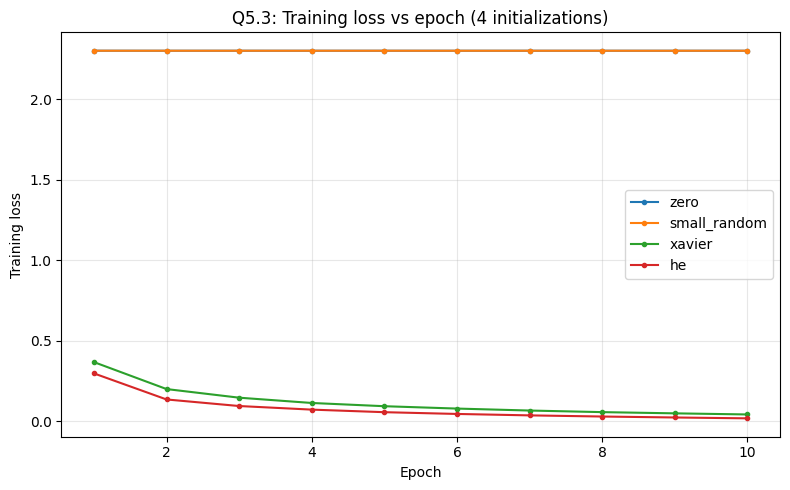

In [5]:
# 1. Plot all 4 training loss curves on the same figure
plt.figure(figsize=(8, 5))
for name in inits:
    plt.plot(range(1, epochs + 1), history[name], "-o", markersize=3, label=name)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Q5.3: Training loss vs epoch (4 initializations)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# 2. Report test accuracy after 10 epochs for each initialization
results = []
for init_name in inits:
    model = models[init_name]
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = 100.0 * correct / total
    results.append((init_name, acc))
    print(f"{init_name}: Test accuracy = {acc:.2f}%")

print("\n--- Summary table ---")
print("Initialization  | Test Accuracy (%)")
print("-" * 35)
for name, acc in results:
    print(f"{name:14s} | {acc:.2f}")

zero: Test accuracy = 11.35%
small_random: Test accuracy = 11.35%
xavier: Test accuracy = 97.66%
he: Test accuracy = 97.85%

--- Summary table ---
Initialization  | Test Accuracy (%)
-----------------------------------
zero           | 11.35
small_random   | 11.35
xavier         | 97.66
he             | 97.85
